In [76]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import neighbors
from sklearn import discriminant_analysis
from sklearn.linear_model import lasso_path
from itertools import cycle
import itertools as it
import matplotlib.pyplot as plt


In [77]:
# 1. Data preparation and exploration

data = pd.read_csv('http://www-stat.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.data', header=0)
data = pd.get_dummies(data, columns=['famhist'])

# a. Train-Test split
fractionOfTraining = 0.5
mask = np.random.rand(len(data)) < fractionOfTraining

train = data[mask]
validation = data[~mask]

# b. Summary statistics

# One-variable

mean = train['chd'].mean()
var = train['chd'].var()
minimum = train['chd'].min()
maximum = train['chd'].max()
firstQuantile = train['chd'].quantile(q=0.25)
median = train['chd'].median()
secondQuantile = train['chd'].quantile(q=0.75)

print ("mean", mean)
print ("variance", var)
print ("min",minimum)
print ("max",maximum)
print ("firstQuantile", firstQuantile)
print ("median",median)
print ("secondQuantile", secondQuantile)


#  Two -variables
correlation = train.corr(method="pearson")
co_variance = train.cov()

print (correlation)


mean 0.33617021276595743
variance 0.224113475177305
min 0
max 1
firstQuantile 0.0
median 0.0
secondQuantile 1.0
                 row.names       sbp   tobacco       ldl  adiposity     typea  \
row.names         1.000000  0.127268 -0.112676 -0.060531   0.002685 -0.171606   
sbp               0.127268  1.000000  0.250022  0.104855   0.341579  0.014696   
tobacco          -0.112676  0.250022  1.000000  0.159553   0.346617  0.054213   
ldl              -0.060531  0.104855  0.159553  1.000000   0.478714  0.028263   
adiposity         0.002685  0.341579  0.346617  0.478714   1.000000 -0.042111   
typea            -0.171606  0.014696  0.054213  0.028263  -0.042111  1.000000   
obesity          -0.039625  0.215410  0.178134  0.330556   0.701297  0.088405   
alcohol           0.191406  0.168836  0.204478 -0.089167   0.134501  0.037373   
age              -0.070090  0.393794  0.442408  0.339636   0.669068 -0.082403   
chd              -0.083076  0.192226  0.276222  0.199492   0.284091  0.130850 

In [78]:
# HIGHLY CORRELATED PREDICTORS: As you can see Family history seems to be strongly connected to chd 
# compared to other variables. Later, the best-subset selection with AIC this will prove to be the best 
# feature that gives predictive information about chd. Similarly 'tobacco' and 'age'. They seem to 
# have a strong correlation and can be used when more features are needed later.

# CATEGORICAL-PREDICTORS: The only categorical predictor in the dataset is familyHist.

# MISSING-VALUES:
print ("\n")
print ("Missing-values present?",data.isnull().values.any())



Missing-values present? False


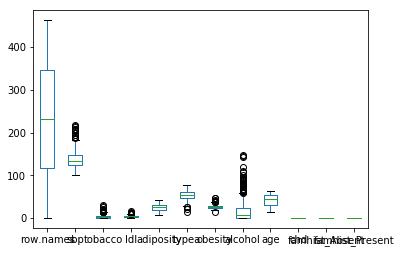

In [79]:
# OUTLIERS:
data.plot.box()
plt.show()

# As you can see there are points that lie outside the box. However, it is not quite clear if we can 
# consider them as noise. Hence, we do not remove any observations.

In [80]:
# 2. Logistic Regression Fit
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent','row.names'],data.axes[1].values[:]))
LRTrainX = train[predictors]
LRTrainY = train.chd

LRModel = linear_model.LogisticRegression()
LRModel.fit(LRTrainX, LRTrainY)

print ("PREDICTORS USED")
print (predictors)
print ("\nCOEFFICIENTS FROM LOGISTIC REGRESSION FIT")
print (LRModel.coef_)
print ("\nINTERCEPT FROM LOGISTIC REGRESSION FIT")
print (LRModel.intercept_)

PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

COEFFICIENTS FROM LOGISTIC REGRESSION FIT
[[ -1.98040502e-03   7.33678783e-02   2.93018575e-02   1.36043102e-01
    3.86959727e-02  -2.59297701e-01   4.04538632e-04   2.13088734e-02
    1.07872402e+00]]

INTERCEPT FROM LOGISTIC REGRESSION FIT
[-1.15946212]


AREA-UNDER-THE-ROC-CURVE 0.804122038299


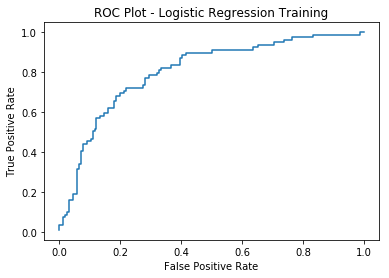

In [81]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = LRTrainX
ROCY = LRTrainY
scores = LRModel.predict_proba(ROCX)
plotTitle = "Logistic Regression Training"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.725773718924


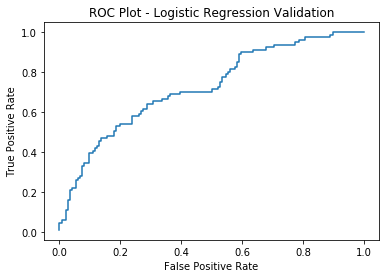

In [82]:
# ROC ON VALIDATION

ROCX = validation[predictors]
ROCY = validation.chd
scores = LRModel.predict_proba(ROCX)
plotTitle = "Logistic Regression Validation"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

SELECTED FEATURE (0.81241454383278255, ['famhist_Present'])


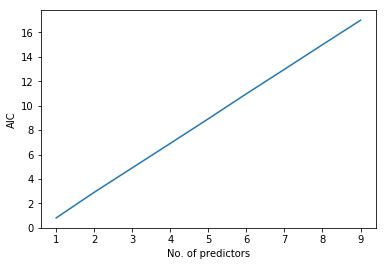

In [83]:
# Variable selection using AIC

predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent','row.names'],data.axes[1].values[:]))

selectionMetrics = {}
lenList = []
aicList = []
for x in range(1,len(predictors)+1):
    subsets = list(it.combinations(predictors, x))
    
    for predictor in subsets:
        predictorsList = list(predictor)
       
        
    x = train[predictorsList]
    y = train.chd

    model = LogisticRegression()

    model.fit(x,y)

    prob = model.predict_proba(train[predictorsList])

    aic = -2*metrics.log_loss(train.chd,prob) + 2*len(predictorsList)
    
    if len(predictorsList) not in selectionMetrics:
        selectionMetrics[len(predictorsList)] = (aic, predictorsList)
        
    else:
        if aic <= selectionMetrics[len(predictorsList)][0]:
            selectionMetrics[len(predictorsList)] = (aic, predictorsList)
            

lenList = selectionMetrics.keys()

aicList = [l[0] for l in selectionMetrics.values()]

print ("SELECTED FEATURE", selectionMetrics[1])
plt.plot(np.reshape(list(selectionMetrics.keys()), 9), np.reshape(aicList, 9))
plt.xlabel("No. of predictors")
plt.ylabel("AIC")
plt.show()


In [84]:
# Fitting with AIC selected feature
AICTrainX = train[['famhist_Present']]
AICTrainY = train.chd

AICModel = linear_model.LogisticRegression()

AICModel.fit(AICTrainX, AICTrainY)
print ("PREDICTORS USED")
print ('famhist_Present')
print ("\nCOEFFICIENTS FROM LOGISTIC REGRESSION FIT")
print (AICModel.coef_)
print ("\nINTERCEPT FROM LOGISTIC REGRESSION FIT")
print (AICModel.intercept_)

PREDICTORS USED
famhist_Present

COEFFICIENTS FROM LOGISTIC REGRESSION FIT
[[ 1.16527948]]

INTERCEPT FROM LOGISTIC REGRESSION FIT
[-1.17231267]


AREA-UNDER-THE-ROC-CURVE 0.656361570919


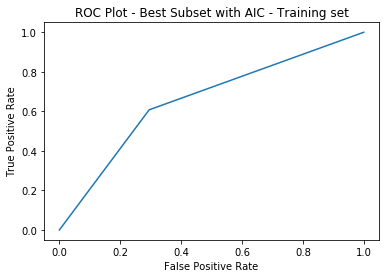

In [85]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = AICTrainX
ROCY = AICTrainY
scores = AICModel.predict_proba(ROCX)
plotTitle = "Best Subset with AIC - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.625063419584


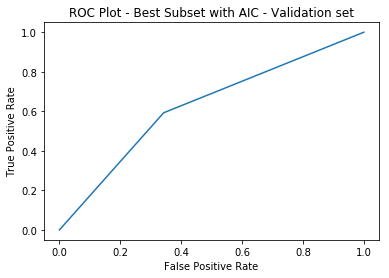

In [86]:
# ROC ON VALIDATION

ROCX = validation[['famhist_Present']]
ROCY = validation.chd
scores = AICModel.predict_proba(ROCX)
plotTitle = "Best Subset with AIC - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

In [87]:
# Above, all subsets are considered and AIC is evaluated to choose the best one across different
# number of predictors. The best subset found with lowest AIC is printed above => The subset with only 
# one feature ['famhist_Present]

In [88]:
# 3. LINEAR DISCRIMINANT ANALYSIS

LDApredictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent', 'famhist_Present','row.names'],data.axes[1].values[:]))
LDATrainX = train[LDApredictors]
LDATrainY = train.chd

LDAModel = discriminant_analysis.LinearDiscriminantAnalysis()

LDAModel.fit(LDATrainX, LDATrainY)
print ("PREDICTORS USED")
print (predictors)
print ("\nCOEFFICIENTS FROM LDA")
print (LDAModel.coef_)
print ("\nINTERCEPT FROM LDA")
print (LDAModel.intercept_)

PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

COEFFICIENTS FROM LDA
[[ 0.00480857  0.06473409  0.09310945  0.05511172  0.04858947 -0.10841262
   0.00063896  0.04343622]]

INTERCEPT FROM LDA
[-5.24982082]


AREA-UNDER-THE-ROC-CURVE 0.776858162934


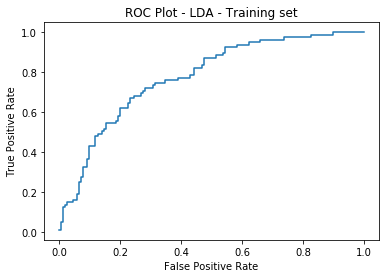

In [89]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = LDATrainX
ROCY = LDATrainY
scores = LDAModel.predict_proba(ROCX)
plotTitle = "LDA - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.757568070353


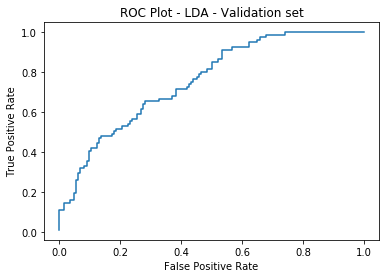

In [90]:
# ROC ON VALIDATION

ROCX = validation[LDApredictors]
ROCY = validation.chd
scores = LDAModel.predict_proba(ROCX)
plotTitle = "LDA - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

In [91]:
# 4. LOGISTIC REGRESSION WITH LASSO REGULARIZATION

# Logistic Regression fit with L1 penalty (Lasso):
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent','row.names'],data.axes[1].values[:]))
x = train[predictors]
y = train.chd

logRegLasso = linear_model.LogisticRegression(penalty='l1')
logRegLasso.fit(x,y)

print ("PREDICTORS USED")
print (predictors)
print ("\nCOEFFICIENTS FROM LOGISTIC REGRESSION WITH LASSO REGULARIZATION")
print (logRegLasso.coef_)
print ("\nINTERCEPT FROM LOGISTIC REGRESSION WITH LASSO REGULARIZATION")
print (logRegLasso.intercept_)

PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

COEFFICIENTS FROM LOGISTIC REGRESSION WITH LASSO REGULARIZATION
[[ -5.13959231e-04   7.03397312e-02   2.60704243e-02   1.25573351e-01
    4.15823665e-02  -2.33842061e-01   3.94755245e-04   2.38048734e-02
    1.07185854e+00]]

INTERCEPT FROM LOGISTIC REGRESSION WITH LASSO REGULARIZATION
[-1.99305838]


AREA-UNDER-THE-ROC-CURVE 0.806069457968


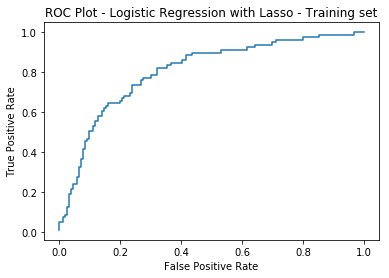

In [92]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = x
ROCY = y
scores = logRegLasso.predict_proba(ROCX)
plotTitle = "Logistic Regression with Lasso - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.730847285642


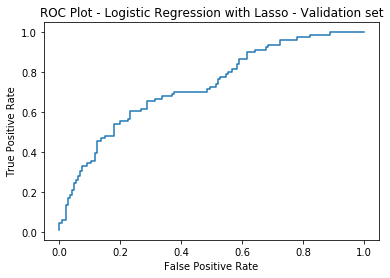

In [93]:
# ROC ON VALIDATION

ROCX = validation[predictors]
ROCY = validation.chd
scores = logRegLasso.predict_proba(ROCX)
plotTitle = "Logistic Regression with Lasso - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

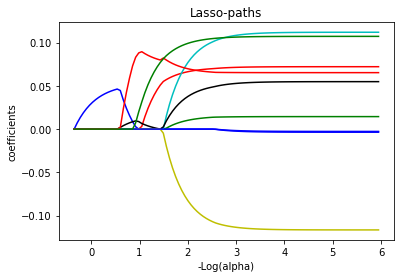

In [94]:

# (a) Lasso path
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent','row.names'],data.axes[1].values[:]))
x = train[predictors]
y = train.chd
x /= x.std(axis=0)
epsilon = 5e-7

alphas_lasso, coefs_lasso, _ = lasso_path(x,y,epsilon,fit_intercept=False)


ax = plt.gca()
colors = cycle(['b', 'r', 'g', 'c', 'k','y'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l,c in zip(coefs_lasso, colors):
    l1= plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    
    
plt.xlabel('-Log(alpha)')    
plt.ylabel('coefficients')
plt.title('Lasso-paths')
plt.axis('tight')
plt.show()


In [95]:
# (a) INTERPRETATION:
# As the negative log(alpha) is minimized, there is more penalty for co-efficients and hence forcing
# them to be zero, as you can see the curves become zero as we go from right to left. This can be used 
# a way to select important features. Based on the alpha, some coefficients may bse set to 0 and 
# dont contribute to the prediction at all.

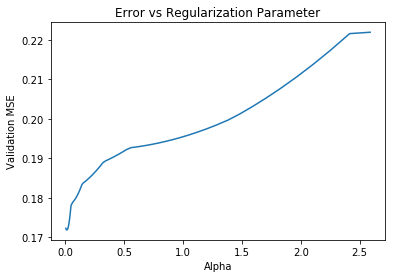

In [96]:
# (b) plot of regularized parameter versus cross-validated predicted error

lassoCVX = data[predictors]
lassoCVY = data.chd

lassoCV = linear_model.LassoCV(cv=2)

lassoCV.fit(lassoCVX, lassoCVY)

alphas,mse=lassoCV.alphas_, lassoCV.mse_path_[:,1]

ax = plt.gca()
# colors = cycle(['b', 'r', 'g', 'c', 'k','y'])
plt.plot(alphas,mse)

plt.xlabel('Alpha')    
plt.ylabel('Validation MSE')
plt.title('Error vs Regularization Parameter')
plt.axis('tight')
plt.show()


In [97]:
# (c) RE-FITTING THE MODEL with alpha = 0.55
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent', 'row.names'],data.axes[1].values[:]))
lassoTrainX = train[predictors]
lassoTrainY = train.chd

lassoModel = linear_model.Lasso(alpha=0.55)

lassoModel.fit(lassoTrainX, lassoTrainY)

print ("PREDICTORS USED")
print (predictors)
print ("\nCOEFFICIENTS FROM LASSO FIT WITH ALPHA=0.55")
print (lassoModel.coef_)
print ("\nINTERCEPT FROM LASSO FIT WITH ALPHA=0.55")
print (lassoModel.intercept_)

PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

COEFFICIENTS FROM LASSO FIT WITH ALPHA=0.55
[ 0.00057537  0.          0.          0.          0.00120884 -0.          0.
  0.00921557  0.        ]

INTERCEPT FROM LASSO FIT WITH ALPHA=0.55
-0.20416233251


In [98]:
# (d) MODEL WITH SELECTED PREDICTORS ONLY

selectedPredictors = ['sbp','typea','age']

selectedX = train[selectedPredictors]
selectedY = train.chd

featureSelected = linear_model.LogisticRegression()

featureSelected.fit(selectedX, selectedY)

print ("PREDICTORS USED")
print (selectedPredictors)
print ("\nCOEFFICIENTS FROM LASSO FIT WITH ALPHA=0.8")
print (featureSelected.coef_)
print ("\nINTERCEPT FROM LASSO FIT WITH ALPHA=0.8")
print (featureSelected.intercept_)

PREDICTORS USED
['sbp', 'typea', 'age']

COEFFICIENTS FROM LASSO FIT WITH ALPHA=0.8
[[-0.00824064  0.00893218  0.05500724]]

INTERCEPT FROM LASSO FIT WITH ALPHA=0.8
[-2.42386947]


AREA-UNDER-THE-ROC-CURVE 0.722857838364


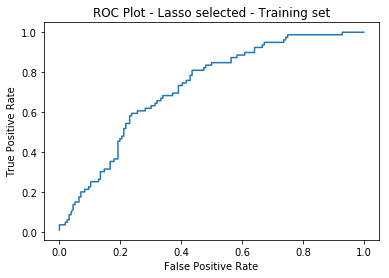

In [99]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = selectedX
ROCY = selectedY
scores = featureSelected.predict_proba(ROCX)
plotTitle = "Lasso selected - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.715837984103


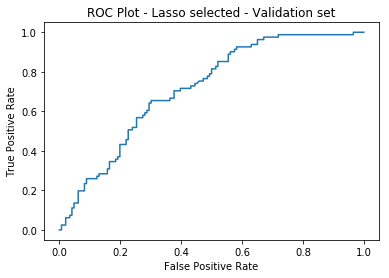

In [100]:
# ROC ON VALIDATION

ROCX = validation[selectedPredictors]
ROCY = validation.chd
scores = featureSelected.predict_proba(ROCX)
plotTitle = "Lasso selected - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, scores[:,1], pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, scores[:,1]))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

In [101]:
# 5. SHRUNKEN CENTROIDS MODEL


# Shrunken Centroids Fit
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent', 'row.names'],data.axes[1].values[:]))
sCentTrainX = train[predictors]
sCentTrainY = train.chd

shrunkenCentroidsModel = neighbors.NearestCentroid()
shrunkenCentroidsModel.fit(sCentTrainX, sCentTrainY)

print ("PREDICTORS USED")
print (predictors)
print ("\nCENTROIDS FOR CLASS 0")
print (shrunkenCentroidsModel.centroids_[0,:])
print ("\nCENTROIDS FOR CLASS 1")
print (shrunkenCentroidsModel.centroids_[1,:])


PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

CENTROIDS FOR CLASS 0
[ 135.37179487    2.83179487    4.43480769   23.8824359    52.61538462
   25.89089744   15.61647436   39.1474359     0.29487179]

CENTROIDS FOR CLASS 1
[ 144.10126582    5.46759494    5.26303797   28.74278481   55.07594937
   26.65911392   18.70151899   50.56962025    0.60759494]


AREA-UNDER-THE-ROC-CURVE 0.64970788705


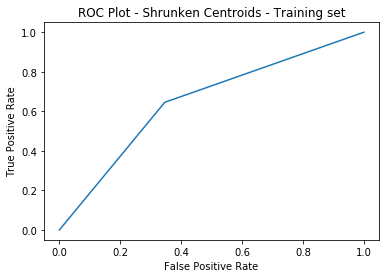

In [102]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = sCentTrainX
ROCY = sCentTrainY
scores = shrunkenCentroidsModel.predict(ROCX)

plotTitle = "Shrunken Centroids - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, np.reshape(scores, len(scores))[np.newaxis].T, pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, np.reshape(scores, len(scores))[np.newaxis].T))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.663453407746


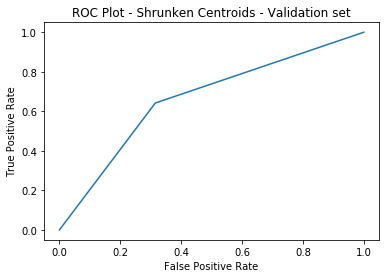

In [103]:
# ROC ON VALIDATION

ROCX = validation[predictors]
ROCY = validation.chd
scores = shrunkenCentroidsModel.predict(ROCX)
plotTitle = "Shrunken Centroids - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, np.reshape(scores, len(scores))[np.newaxis].T, pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, np.reshape(scores, len(scores))[np.newaxis].T))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

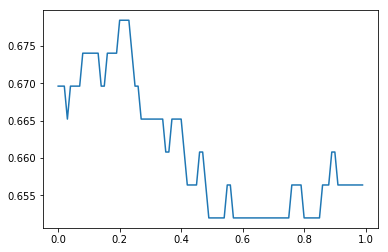

In [104]:
# (a) CROSS-VALIDATION TO SELECT REGULARIZATION PARAMETER
predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent', 'row.names'],data.axes[1].values[:]))

thresholds = [None]+[x*0.01 for x in range(0,100)]
testX = train[predictors]
testY = train.chd
valX = validation[predictors]
valY = validation.chd
meanAccuracies = {}
accuracies = []
for threshold in thresholds:
    nearestCentroidModel = neighbors.NearestCentroid(shrink_threshold=threshold)
    
    nearestCentroidModel.fit(testX, testY)
    
    score = nearestCentroidModel.score(valX,valY)
    accuracies.append(score)
    meanAccuracies[threshold] = score

# print (meanAccuracies)

plt.plot(thresholds, accuracies)
plt.show()
plt.xlabel('Thresholds')
plt.ylabel('Mean-Accuracies')

In [106]:
# (b) Refit the model with Regularization Parameter = 0.22

predictors = list(filter(lambda x:x not in ['chd', 'famhist_Absent', 'row.names'],data.axes[1].values[:]))
sCentTrainX = train[predictors]
sCentTrainY = train.chd

shrunkenCentroidsModel = neighbors.NearestCentroid(shrink_threshold = 0.22)
shrunkenCentroidsModel.fit(sCentTrainX, sCentTrainY)

print ("PREDICTORS USED")
print (predictors)
print ("\nCENTROIDS FOR CLASS 0")
print (shrunkenCentroidsModel.centroids_[0,:])
print ("\nCENTROIDS FOR CLASS 1")
print (shrunkenCentroidsModel.centroids_[1,:])

PREDICTORS USED
['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Present']

CENTROIDS FOR CLASS 0
[ 136.02898071    3.10746303    4.65547261   24.23606236   52.9931479
   26.14914894   16.34489394   39.63168339    0.4       ]

CENTROIDS FOR CLASS 1
[ 143.27367933    5.12044923    4.98515721   28.29746711   54.60023645
   26.31137606   17.78422867   49.95981301    0.4       ]


AREA-UNDER-THE-ROC-CURVE 0.668614086336


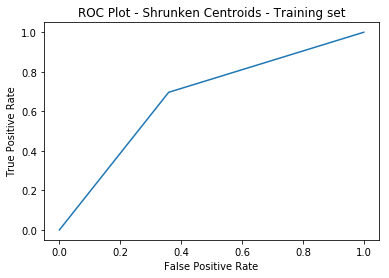

In [107]:
# PERFORMANCE-EVALUATION

# ROC ON TRAINING
ROCX = sCentTrainX
ROCY = sCentTrainY
scores = shrunkenCentroidsModel.predict(ROCX)

plotTitle = "Shrunken Centroids - Training set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, np.reshape(scores, len(scores))[np.newaxis].T, pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, np.reshape(scores, len(scores))[np.newaxis].T))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

AREA-UNDER-THE-ROC-CURVE 0.673050904786


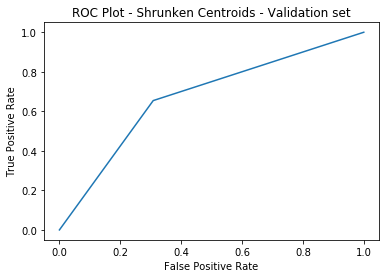

In [108]:
# ROC ON VALIDATION

ROCX = validation[predictors]
ROCY = validation.chd
scores = shrunkenCentroidsModel.predict(ROCX)
plotTitle = "Shrunken Centroids - Validation set"

fpr, tpr, thresholds = metrics.roc_curve(ROCY, np.reshape(scores, len(scores))[np.newaxis].T, pos_label=1)
print ("AREA-UNDER-THE-ROC-CURVE", metrics.roc_auc_score(ROCY, np.reshape(scores, len(scores))[np.newaxis].T))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Plot - "+plotTitle)
plt.show()

In [ ]:
# VIZUALIZING CENTROIDS
# Centroids can be vizualized using Fischer's discriminant plot using K-1 axes (K is the number of features). The reason it 
# cannot be plotted here because in our case K = 9. So we need 8 dimensions to visualize centroids for each feature.

In [75]:
# 6. PERFORMANCE EVALUATION

# All the ROC curves discussed in this section are produced in the previous sections along with the 
# corresponding classifier. I am just goind to use those data and provide my interpretations.
# I have done it in this way because I felt it was more easier if all things are in one place, please
# look above for the curves and information about them. They are plotted and presented.

# (a) ROC curves on Training Data:
#     All ROC plots for the training data are provided in the previous sections along with 
#     the area under the curve

# (b) ROC curves on Validation Data:
#     All ROC plots for the validation data are provided in the previous sections along with 
#     the area under the curve

# (c) SUMMARY -
# The metric used in this section is the Area under the ROC curve. The chosen model is better if the
# area under ROC curve is closer to 1.0 (TP rate is higher and FP rate is very low).

# 1.Area under ROC is generally higher in training sets compared to validation sets (but the difference
#   is small - about 0.1).

# 2.Only the Regularized and Non-Regularized Shrunken Centroid model has higher AUC (Area-under-curve)
#   in the validation data than training data.
# In other words, all methods except Shrunken Centroid model perform bad on the validation set.
# The model that performed best on validation set is LDA which has the 
# highest AUC at 0.75 compared to others.

# 3. One reason for this behaviour may be due to overfitting in the models, where it has learnt too
#    much about the training set that it fails to perform well for newer datasets.
#    I also observed changes in these values when based on the Train-Test random split.

# 4. All the regularized models are quite interpretable because of the fact that it has a relatively
#    lower number of features. These selected features also reflect high correlation with target
#    variable.



In [ ]:
# 7. Kevin Murphy Exercise 4.20

# a. Gaussl vs LinLog
#    When the classes are well separated, logistic regression is less stable, coeffs tend to infinity.
#    In such cases, L(Gaussl) > L(LinLog)

# b. GaussX vs QuadLog
#    On the training data QuadLog tends to take up the shape even more flexibly, giving rise to over fitting.
#     Hence considerng the training set alone L(QuadLog) > L(GuassX)

# c. LinLog vs QuadLog
#   Similar to the arguments above, QuadLog tends to take up the shape even more flexibly, giving rise to over fitting.
#     Hence considerng the training set alone L(QuadLog) > L(LinLog)

# d. Guassl vs QuadLog
#    QuadLog becomes less stable when the classes are well-separated. This is denoted by a lower Log likehood for QuadLog.

# e. We cannot conclude any implications between miclassification and log likelihood because, a class can be more likely even 
#   though the features are not favorable due to several other factors in the data. Log likelihood is only a probability, we
#   cannot draw any conclusions.